# Selects the best model with the best hyperparameter combination

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

from catboost import CatBoostRegressor
from bayes_opt import BayesianOptimization

In [2]:
# Load configuration
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [3]:
# Load data
data = pd.read_csv('../data/winequality_red.csv')

In [4]:
# Data Cleaning and Exploratory Data Analysis
print("Data shape:", data.shape)
print("\nMissing values:")
print(data.isnull().sum())

Data shape: (1599, 12)

Missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [5]:
# Check for duplicates
duplicates = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 240


In [6]:
# Remove duplicates if any
if duplicates > 0:
    data = data.drop_duplicates()

In [7]:
# Descriptive statistics
print("\nDescriptive statistics:")
print(data.describe())


Descriptive statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1359.000000       1359.000000  1359.000000     1359.000000   
mean        8.310596          0.529478     0.272333        2.523400   
std         1.736990          0.183031     0.195537        1.352314   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.430000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1359.000000          1359.000000           1359.000000  1359.000000   
mean      0.088124            15.893304             46.825975     0.996709   
std       0.049377            10.447270             33.408946     0.001869   
min       0.012000     

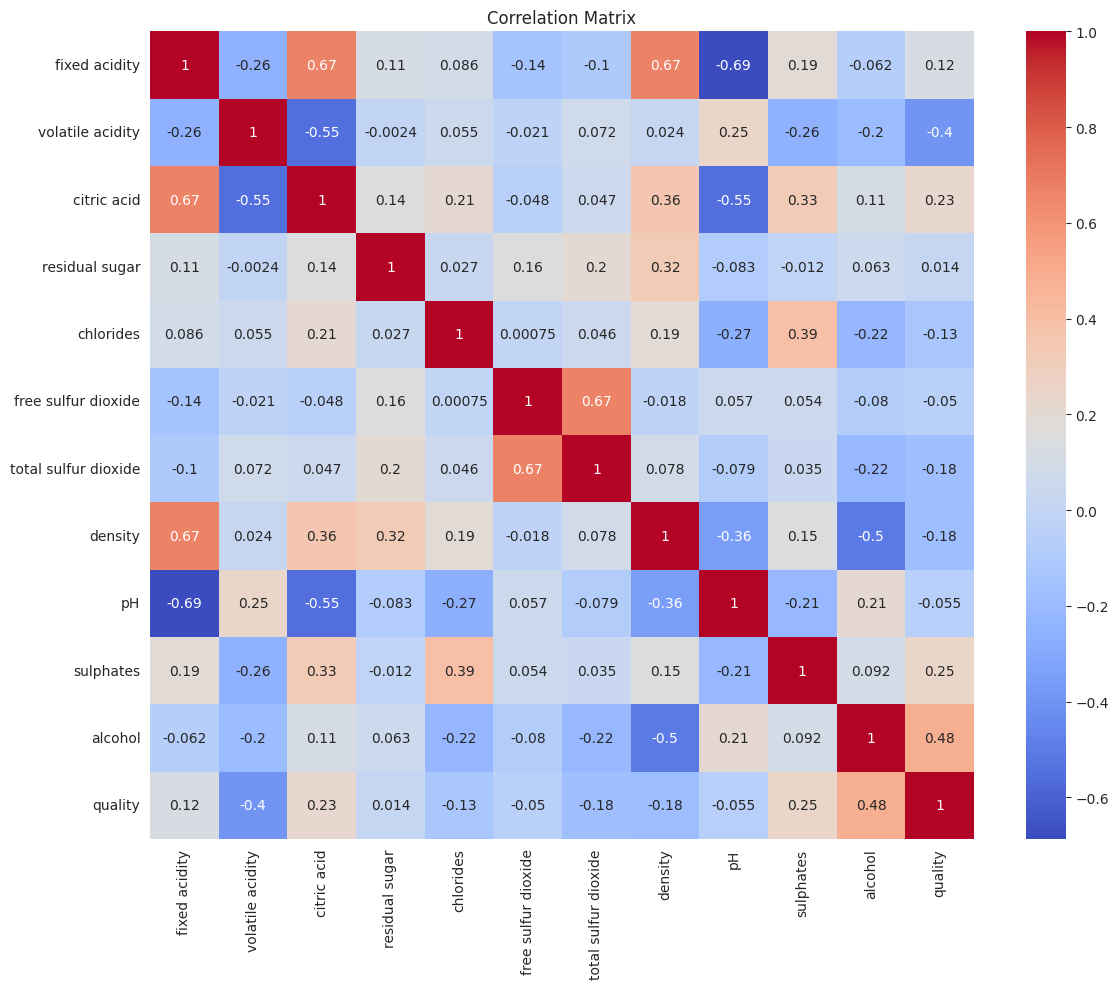

In [43]:
# Correlation matrix
plots_dir = "./"
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'correlation_matrix.png'))
plt.show()  # Display in the notebook

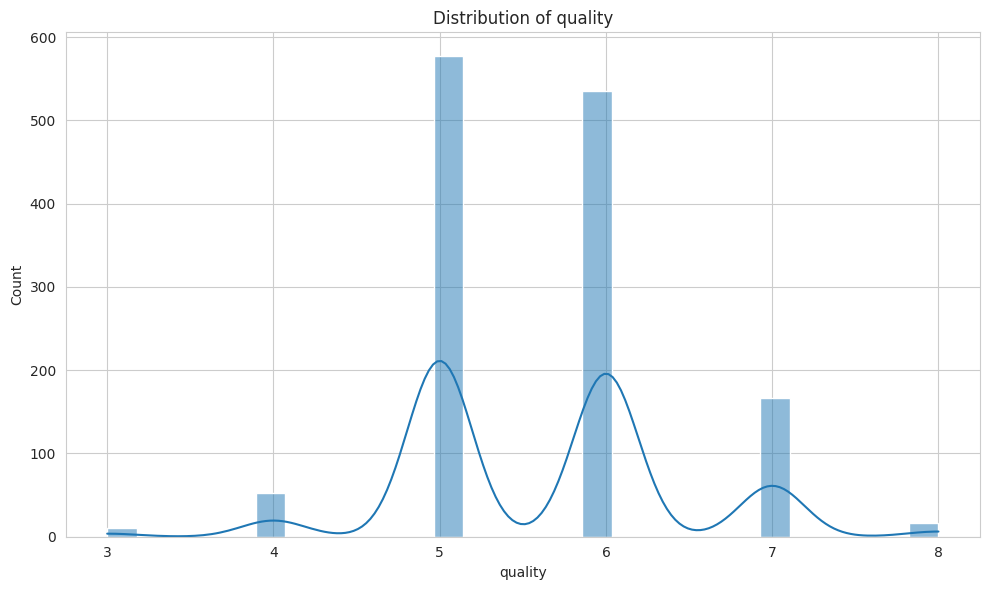

In [44]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data[config['target']], kde=True)
plt.title(f'Distribution of {config["target"]}')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'target_distribution.png'))
plt.show()  # Display in the notebook

In [9]:
# Outlier detection using IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

In [10]:
# Detect and print outliers for each column
for column in data.columns:
    outliers = detect_outliers(data, column)
    print(f"\nOutliers in {column}: {len(outliers)}")


Outliers in fixed acidity: 41

Outliers in volatile acidity: 19

Outliers in citric acid: 1

Outliers in residual sugar: 126

Outliers in chlorides: 87

Outliers in free sulfur dioxide: 26

Outliers in total sulfur dioxide: 45

Outliers in density: 35

Outliers in pH: 28

Outliers in sulphates: 55

Outliers in alcohol: 12

Outliers in quality: 27


In [11]:
# Feature selection
X = data.drop(config['target'], axis=1)
y = data[config['target']]

In [12]:
# Select top k features
k = 8  # You can adjust this value
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X, y)

In [13]:
# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()
print("\nSelected features:", selected_features)


Selected features: ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']


In [14]:
# Update X with selected features
X = X[selected_features]

In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['test_size'], random_state=42)

In [16]:
def optimize_rf(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    max_depth = None if max_depth > 100 else int(max_depth)
    max_features_options = config['rf_hp']['max_features']
    max_features_index = int(max_features * len(max_features_options))
    max_features = max_features_options[max_features_index]
    
    if max_features == '1.0':
        max_features = 1.0
    
    model = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=max_depth,
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=max_features,
        random_state=42
    )
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    score = cross_val_score(
        pipeline, X_train, y_train, 
        cv=StratifiedKFold(n_splits=config['cross_validation']['n_splits'], shuffle=True, random_state=42),
        scoring='neg_mean_squared_error'
    ).mean()
    return score

In [17]:
def optimize_catboost(iterations, depth, learning_rate, l2_leaf_reg):
    model = CatBoostRegressor(
        iterations=int(iterations),
        depth=int(depth),
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_state=42,
        verbose=False
    )
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    score = cross_val_score(
        pipeline, X_train, y_train, 
        cv=StratifiedKFold(n_splits=config['cross_validation']['n_splits'], shuffle=True, random_state=42),
        scoring='neg_mean_squared_error'
    ).mean()
    return score

### Define Search space for Random Forest
- hyperparameters:
- n_estimators: Number of trees in the forest.
- max_depth: Maximum depth of trees (110 allows for None, which means unlimited depth).
- min_samples_split: Minimum samples required to split an internal node.
- min_samples_leaf: Minimum samples required at a leaf node.
- max_features: Fraction of features to consider for best split.

In [18]:
# Define the parameter space for optimization
rf_params = {
    'n_estimators': (min(config['rf_hp']['n_estimators']), max(config['rf_hp']['n_estimators'])),
    'max_depth': (5, 110),
    'min_samples_split': (min(config['rf_hp']['min_samples_split']), max(config['rf_hp']['min_samples_split'])),
    'min_samples_leaf': (min(config['rf_hp']['min_samples_leaf']), max(config['rf_hp']['min_samples_leaf'])),
    'max_features': (0, 0.9999)
}

### Define Search space for Random Forest & CatBoost
- hyperparameters:
- iterations: Number of boosting iterations.
- depth: Maximum depth of trees.
- learning_rate: Step size shrinkage used in update to prevents overfitting.
- l2_leaf_reg: L2 regularization coefficient.

In [19]:
catboost_params = {
    'iterations': (min(config['catboost_hp']['iterations']), max(config['catboost_hp']['iterations'])),
    'depth': (min(config['catboost_hp']['depth']), max(config['catboost_hp']['depth'])),
    'learning_rate': (min(config['catboost_hp']['learning_rate']), max(config['catboost_hp']['learning_rate'])),
    'l2_leaf_reg': (min(config['catboost_hp']['l2_leaf_reg']), max(config['catboost_hp']['l2_leaf_reg']))
}

In [20]:
# Optimize Random Forest
rf_optimizer = BayesianOptimization(f=optimize_rf, pbounds=rf_params, random_state=42)
rf_optimizer.maximize(init_points=config['optimization']['init_points'], n_iter=config['optimization']['n_iter'])


|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.4235   | 44.33     | 0.9506    | 3.196     | 6.789     | 198.2     |
| 2         | -0.4224   | 21.38     | 0.05808   | 3.599     | 6.809     | 722.7     |
| 3         | -0.4226   | 7.161     | 0.9698    | 3.497     | 3.699     | 222.7     |
| 4         | -0.4176   | 24.26     | 0.3042    | 2.574     | 5.456     | 326.7     |
| 5         | -0.4273   | 69.24     | 0.1395    | 1.876     | 4.931     | 483.3     |
| 6         | -0.4261   | 87.44     | 0.1997    | 2.543     | 6.739     | 94.13     |
| 7         | -0.4259   | 68.79     | 0.1705    | 1.195     | 9.591     | 967.4     |
| 8         | -0.4174   | 89.88     | 0.3046    | 1.293     | 7.474     | 468.1     |
| 9         | -0.4199   | 17.81     | 0.4951    | 1.103     | 9.275     | 295.8     |
| 10        | -0.4165   | 74.56     | 0.3117    | 2.56

In [21]:
# Create the best_rf model
best_rf = RandomForestRegressor(
    n_estimators=int(rf_optimizer.max['params']['n_estimators']),
    max_depth=None if rf_optimizer.max['params']['max_depth'] > 100 else int(rf_optimizer.max['params']['max_depth']),
    min_samples_split=int(rf_optimizer.max['params']['min_samples_split']),
    min_samples_leaf=int(rf_optimizer.max['params']['min_samples_leaf']),
    max_features=config['rf_hp']['max_features'][int(rf_optimizer.max['params']['max_features'] * len(config['rf_hp']['max_features']))],
    random_state=42
)

## Optimize CatBoost
catboost_optimizer = BayesianOptimization(f=optimize_catboost, pbounds=catboost_params, random_state=42)
catboost_optimizer.maximize(init_points=config['optimization']['init_points'], n_iter=config['optimization']['n_iter'])

In [23]:
best_catboost = CatBoostRegressor(
    iterations=int(catboost_optimizer.max['params']['iterations']),
    depth=int(catboost_optimizer.max['params']['depth']),
    learning_rate=catboost_optimizer.max['params']['learning_rate'],
    l2_leaf_reg=catboost_optimizer.max['params']['l2_leaf_reg'],
    random_state=42,
    verbose=False
)

In [24]:
# Train and evaluate best models
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', best_rf)
])
rf_pipeline.fit(X_train, y_train)
rf_mse = mean_squared_error(y_test, rf_pipeline.predict(X_test))

In [25]:
catboost_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', best_catboost)
])
catboost_pipeline.fit(X_train, y_train)
catboost_mse = mean_squared_error(y_test, catboost_pipeline.predict(X_test))

## Select best model

In [26]:
# Select best model
if rf_mse < catboost_mse:
    print("\nBest Model: Random Forest")
    best_model = rf_pipeline
    best_mse = rf_mse
    model_filename = "random_forest_model.joblib"
else:
    print("\nBest Model: CatBoost")
    best_model = catboost_pipeline
    best_mse = catboost_mse
    model_filename = "catboost_model.joblib"

print(f"Best Model MSE: {best_mse}")

# Save the best model
model_dir = Path("../models")
model_path = model_dir / model_filename
joblib.dump(best_model, model_path)
print(f"Best model saved to {model_path}")


Best Model: CatBoost
Best Model MSE: 0.38044684562129083
Best model saved to ../models/catboost_model.joblib


In [27]:
# Save the MSE along with the model
mse_filename = "best_model_mse.txt"
mse_path = model_dir / mse_filename
with open(mse_path, "w") as f:
    f.write(f"Best Model MSE: {best_mse}")
print(f"Best model MSE saved to {mse_path}")

Best model MSE saved to ../models/best_model_mse.txt


In [ ]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data[config['target']], kde=True)
plt.title(f'Distribution of {config["target"]}')
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'target_distribution.png'))
plt.show()  # Display in the notebook

#  Plotting

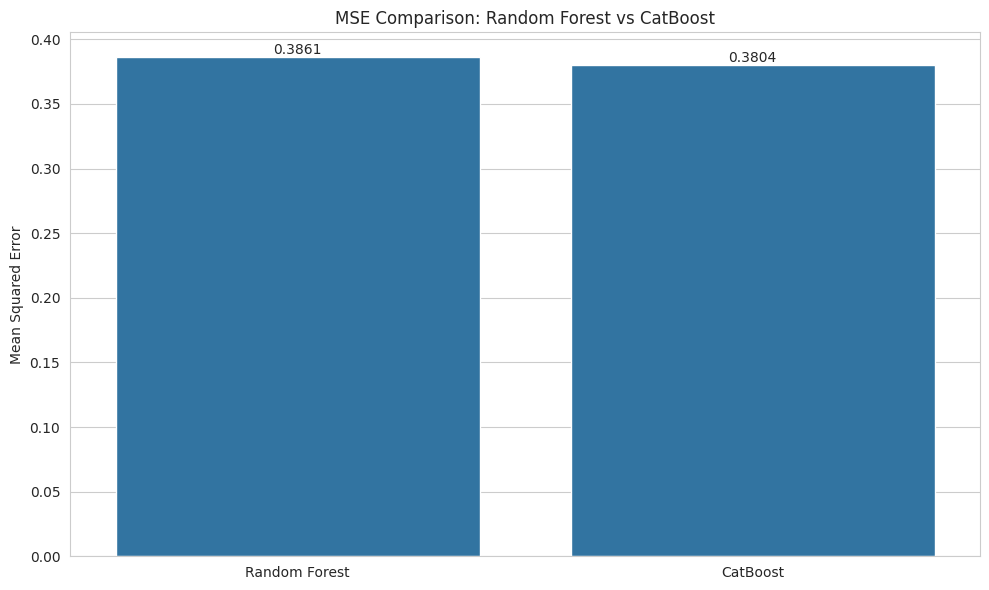

In [68]:
# MSE Comparison
plt.style.use('default')
sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(10, 6))

mse_data = {'Random Forest': rf_mse, 'CatBoost': catboost_mse}
sns.barplot(x=list(mse_data.keys()), y=list(mse_data.values()), ax=ax1)
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('MSE Comparison: Random Forest vs CatBoost')
for i, v in enumerate(mse_data.values()):
    ax1.text(i, v, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'mse_comparison.png'))
plt.show()

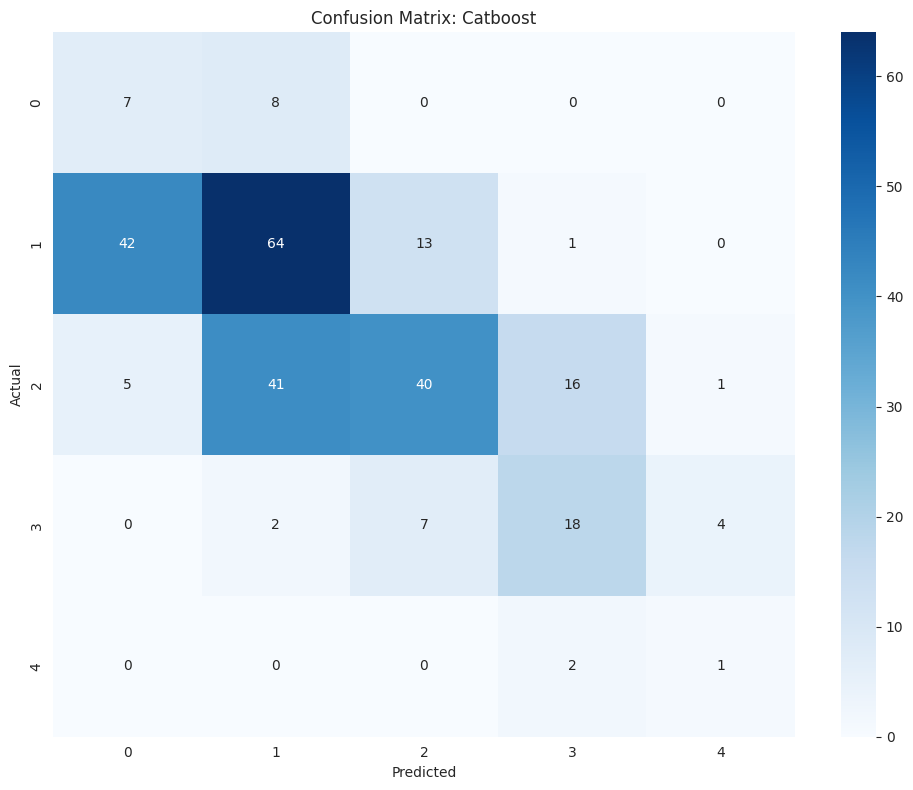

In [69]:
# Plot confusion matrix
fig, ax2 = plt.subplots(figsize=(10, 8))

y_pred = best_model.predict(X_test)

def bin_values(y):
    return pd.cut(y, bins=5, labels=[1, 2, 3, 4, 5])

y_test_binned = bin_values(y_test)
y_pred_binned = bin_values(y_pred)

cm = confusion_matrix(y_test_binned, y_pred_binned)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_title(f'Confusion Matrix: {model_filename.split("_")[0].capitalize()}')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'confusion_matrix.png'))
plt.show()

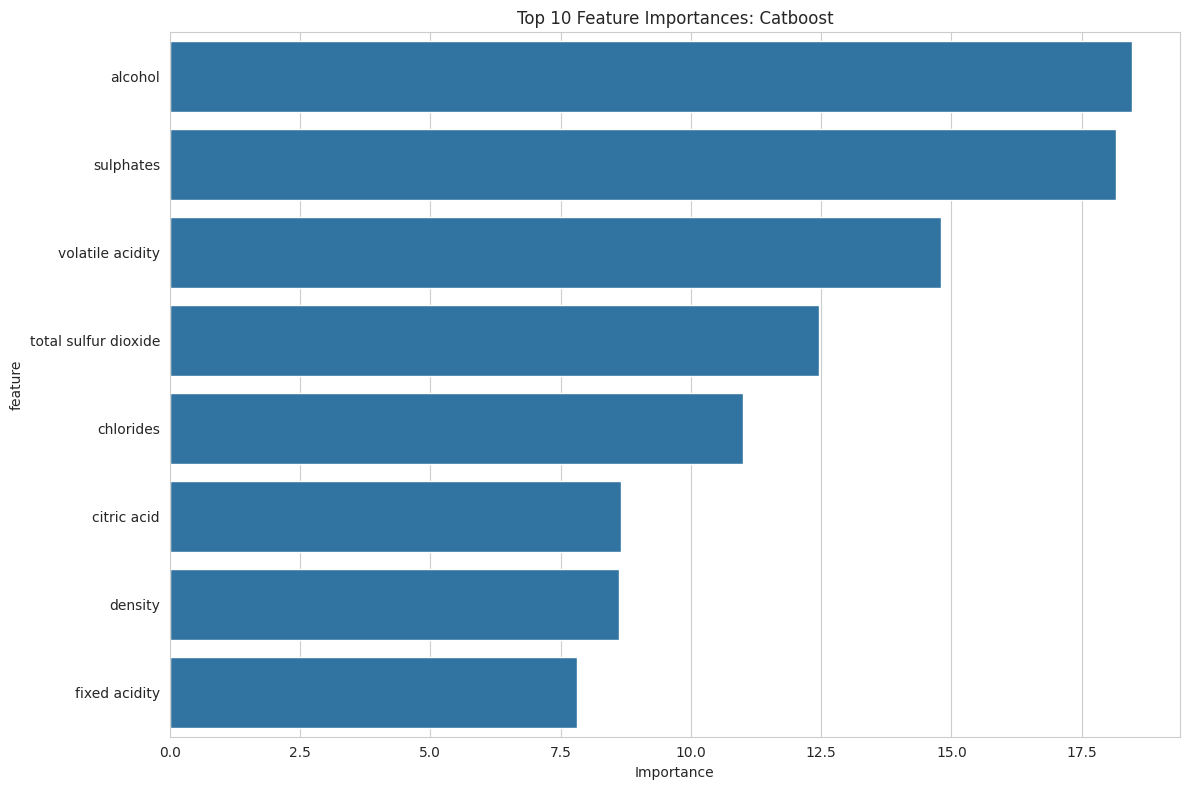

All plots have been saved in the './' directory and displayed in the notebook.


In [70]:
# Feature Importance (Best Model)
fig, ax3 = plt.subplots(figsize=(12, 8))

if isinstance(best_model.named_steps['model'], RandomForestRegressor):
    feature_importance = dict(zip(X.columns, best_model.named_steps['model'].feature_importances_))
else:  # CatBoost
    feature_importance = dict(zip(X.columns, best_model.named_steps['model'].feature_importances_))

features = list(feature_importance.keys())
importances = list(feature_importance.values())
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)

sns.barplot(x='importance', y='feature', data=feature_importance_df, ax=ax3)
ax3.set_xlabel('Importance')
ax3.set_title(f'Top 10 Feature Importances: {model_filename.split("_")[0].capitalize()}')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'feature_importance.png'))
plt.show()

print(f"All plots have been saved in the '{plots_dir}' directory and displayed in the notebook.")

In [61]:
# After saving and displaying the model comparison plot
print(f"Model comparison plot has been saved in the '{plots_dir}' directory and displayed in the notebook.")

# Function to format hyperparameters
def format_hyperparameters(params):
    formatted = ""
    for key, value in params.items():
        if isinstance(value, float):
            formatted += f"  {key:<20}: {value:.4f}\n"
        else:
            formatted += f"  {key:<20}: {value}\n"
    return formatted

# Print out the best hyperparameters for each model
print("\nBest Random Forest Hyperparameters:")
print(format_hyperparameters(rf_optimizer.max['params']))

print("\nBest CatBoost Hyperparameters:")
print(format_hyperparameters(catboost_optimizer.max['params']))

# Select and print the best model
if rf_mse < catboost_mse:
    best_model_name = "Random Forest"
    best_model = rf_pipeline
    best_mse = rf_mse
    model_filename = "random_forest_model.joblib"
else:
    best_model_name = "CatBoost"
    best_model = catboost_pipeline
    best_mse = catboost_mse
    model_filename = "catboost_model.joblib"

print(f"\nBest Model: {best_model_name}")
print(f"Best Model MSE: {best_mse:.4f}")

# Save the best model
model_path = os.path.join(model_dir, model_filename)
joblib.dump(best_model, model_path)
print(f"Best model saved to: {model_path}")

# Save the MSE along with the model
mse_filename = "best_model_mse.txt"
mse_path = os.path.join(model_dir, mse_filename)
with open(mse_path, "w") as f:
    f.write(f"Best Model MSE: {best_mse:.4f}")
print(f"Best model MSE saved to: {mse_path}")

Model comparison plot has been saved in the './' directory and displayed in the notebook.

Best Random Forest Hyperparameters:
  max_depth           : 75.7754
  max_features        : 0.6795
  min_samples_leaf    : 2.7900
  min_samples_split   : 7.8936
  n_estimators        : 225.3050


Best CatBoost Hyperparameters:
  depth               : 9.8643
  iterations          : 563.6146
  l2_leaf_reg         : 3.9053
  learning_rate       : 0.0208


Best Model: CatBoost
Best Model MSE: 0.3804
Best model saved to: ../models/catboost_model.joblib
Best model MSE saved to: ../models/best_model_mse.txt
